## Поставим задачу сравнить погодные данные для произвольных городов мира, находящихся на одной широте, выгрузив их в датафрейм

Загрузим все необходимые модули и библиотеки:

In [ ]:
# установим необходимые библиотеки
!pip install bs4
!pip install requests
!pip install texttable
!pip install itertools
!pip install pip install ujson

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [ ]:
# загрузим необходимые библиотеки
import requests
from bs4 import BeautifulSoup
import texttable as tt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import re
import pytest
import ujson
import argparse

from requests.exceptions import Timeout
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import matplotlib
import matplotlib.pyplot as plt
import folium

Подготовим необходимые данные для анализа:

* в excel создали список городов, которые будем рассматривать в анном анализе, с данными по широте и долготе

* загружаем данный список в наш анализ

In [ ]:
# Загрузим наш датасет с координатами городов, находящихся примерно на одной широте (latitude), через библиотеку pandas
df = pd.read_excel("cities.xlsx", na_values = ['na',], header = 0)

# Выведем на экран первые 10 строк датасета
df.head(10)

,City,Latitude,Longitude
0,Seoul,37.532600,127.024612
1,Beijing,39.922516,116.396011
2,Ashgabat,37.962099,58.310749
3,İzmir,38.441299,27.145817
4,Athena,37.982126,23.730089
5,Palermo,38.121413,13.366828
6,Lisbon,38.726445,-9.143176
7,Washington,38.916344,-77.030422


In [ ]:
# выведем информацию по городам в нашем датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       8 non-null      object 
 1   Latitude   8 non-null      float64
 2   Longitude  8 non-null      float64
dtypes: float64(2), object(1)
memory usage: 320.0+ bytes


In [ ]:
# создадим список названий дней недели, используемых на сайте яндекс.погоды
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
print(days)

['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']


Возьмем данные с сайта погоды:

In [ ]:
# рассмотрим данные прогноза погоды с сайта яндекс.погоды
URL_FORMATTED = 'https://yandex.com.am/weather/?lat={city_latitude}&lon={city_lontitude}'


url_seoul = URL_FORMATTED.format(city_latitude = df.iloc [0]['Latitude'], city_lontitude = df.iloc [0]['Longitude'])
url_beijing = URL_FORMATTED.format(city_latitude = df.iloc [1]['Latitude'], city_lontitude = df.iloc [1]['Longitude'])
url_ashgabat = URL_FORMATTED.format(city_latitude = df.iloc [2]['Latitude'], city_lontitude = df.iloc [2]['Longitude'])
url_izmir = URL_FORMATTED.format(city_latitude = df.iloc [3]['Latitude'], city_lontitude = df.iloc [3]['Longitude'])
url_athena = URL_FORMATTED.format(city_latitude = df.iloc [4]['Latitude'], city_lontitude = df.iloc [4]['Longitude'])
url_palermo = URL_FORMATTED.format(city_latitude = df.iloc [5]['Latitude'], city_lontitude = df.iloc [5]['Longitude'])
url_lisbon = URL_FORMATTED.format(city_latitude = df.iloc [6]['Latitude'], city_lontitude = df.iloc [6]['Longitude'])
url_washington = URL_FORMATTED.format(city_latitude = df.iloc [7]['Latitude'], city_lontitude = df.iloc [7]['Longitude'])


print(url_seoul)
page = requests.get(url_seoul)
bs = BeautifulSoup(page.text, 'html.parser')

https://yandex.com.am/weather/?lat=37.5326&lon=127.024612


Выгрузим данные по погоде по интересующим нас городам

# Сеул, Южная Корея

In [ ]:
# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_seoul = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_seoul.drop(columns=["weather_id"], inplace=True)
df_seoul = df_seoul.sort_values('current_date')
df_seoul.reset_index(drop= True , inplace= True ) # Сеул
df_seoul

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-11-01,Ср,23,17,Облачно с прояснениями
1,2023-11-02,Чт,24,17,Малооблачно
2,2023-11-03,Пт,21,15,Дождь
3,2023-11-04,Сб,18,14,Пасмурно
4,2023-11-05,Вс,18,9,Дождь
5,2023-11-06,Пн,10,4,Небольшой дождь
6,2023-11-07,Вт,12,6,Ясно


# Пекин, Китай

In [ ]:
# возьмем данные для Пекина (Beijing)
page = requests.get(url_beijing)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_beijing = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_beijing.drop(columns=["weather_id"], inplace=True)
df_beijing = df_beijing.sort_values('current_date')
df_beijing.reset_index(drop= True , inplace= True )
df_beijing # Beijing

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-11-01,Ср,24,12,Ясно
1,2023-11-02,Чт,21,12,Облачно с прояснениями
2,2023-11-03,Пт,18,6,Ясно
3,2023-11-04,Сб,17,8,Малооблачно
4,2023-11-05,Вс,14,4,Малооблачно
5,2023-11-06,Пн,13,3,Ясно
6,2023-11-07,Вт,13,5,Ясно


Ашхабад, Туркменистан

In [ ]:
# возьмем данные для Ашхабада (Ashgabat)
page = requests.get(url_ashgabat)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_ashgabat = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_ashgabat.drop(columns=["weather_id"], inplace=True)
df_ashgabat = df_ashgabat.sort_values('current_date')
df_ashgabat.reset_index(drop= True , inplace= True )
df_ashgabat # ashgabat

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-11-01,Ср,22,8,Ясно
1,2023-11-02,Чт,25,10,Ясно
2,2023-11-03,Пт,24,14,Облачно с прояснениями
3,2023-11-04,Сб,24,15,Облачно с прояснениями
4,2023-11-05,Вс,22,15,Облачно с прояснениями
5,2023-11-06,Пн,22,14,Облачно с прояснениями
6,2023-11-07,Вт,23,12,Ясно


# Измир, Турция

In [ ]:
# возьмем данные для Измира (Izmir)
page = requests.get(url_izmir)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_izmir = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_izmir.drop(columns=["weather_id"], inplace=True)
df_izmir = df_izmir.sort_values('current_date')
df_izmir.reset_index(drop= True , inplace= True )
df_izmir # izmir

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-10-31,Вт,26,18,Ясно
1,2023-11-01,Ср,25,20,Облачно с прояснениями
2,2023-11-02,Чт,24,20,Небольшой дождь
3,2023-11-03,Пт,26,22,Облачно с прояснениями
4,2023-11-04,Сб,27,21,Облачно с прояснениями
5,2023-11-05,Вс,24,20,Дождь
6,2023-11-06,Пн,23,19,Облачно с прояснениями


# Афины, Греция

In [ ]:
# возьмем данные для Афин (Athena)
page = requests.get(url_athena)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_athena = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_athena.drop(columns=["weather_id"], inplace=True)
df_athena = df_athena.sort_values('current_date')
df_athena.reset_index(drop= True , inplace= True )
df_athena # athena

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-10-28,Сб,27,18,Малооблачно
1,2023-10-31,Вт,25,17,Ясно
2,2023-11-01,Ср,26,19,Облачно с прояснениями
3,2023-11-02,Чт,26,18,Малооблачно
4,2023-11-03,Пт,25,21,Облачно с прояснениями
5,2023-11-05,Вс,23,18,Малооблачно
6,2023-11-06,Пн,24,16,Облачно с прояснениями


# Палермо, Италия

In [ ]:
# возьмем данные для Палермо (Palermo)
page = requests.get(url_palermo)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_palermo = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_palermo.drop(columns=["weather_id"], inplace=True)
df_palermo = df_palermo.sort_values('current_date')
df_palermo.reset_index(drop= True , inplace= True )
df_palermo # palermo

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-10-28,Сб,26,18,Ясно
1,2023-10-31,Вт,25,18,Облачно с прояснениями
2,2023-11-01,Ср,23,19,Небольшой дождь
3,2023-11-02,Чт,25,22,Малооблачно
4,2023-11-03,Пт,23,16,Дождь
5,2023-11-05,Вс,24,19,Облачно с прояснениями
6,2023-11-06,Пн,22,16,Облачно с прояснениями


# Лиссабон, Португалия

In [ ]:
# возьмем данные для Лиссабона (Lisbon)
page = requests.get(url_lisbon)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_lisbon = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_lisbon.drop(columns=["weather_id"], inplace=True)
df_lisbon = df_lisbon.sort_values('current_date')
df_lisbon.reset_index(drop= True , inplace= True )
df_lisbon # lisbon

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-10-31,Вт,18,17,Облачно с прояснениями
1,2023-11-01,Ср,20,19,Дождь
2,2023-11-02,Чт,19,15,Небольшой дождь
3,2023-11-03,Пт,18,18,Облачно с прояснениями
4,2023-11-04,Сб,20,16,Дождь
5,2023-11-05,Вс,19,14,Облачно с прояснениями
6,2023-11-06,Пн,18,13,Облачно с прояснениями


# Вашингтон, США

In [ ]:
# возьмем данные для Вашингтона (Washington)
page = requests.get(url_washington)
bs = BeautifulSoup(page.text, 'html.parser')

# создадим список для хранения информации о погоде
weather_data= []


# добавим переменную для автоматической генерации WeatherID
weather_id = 1

for day in days:
    date = bs.find('div', class_="forecast-briefly__name", text=day).find_next('time', class_="time forecast-briefly__date")['datetime']
    day_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_day').find('span', class_='temp__value').text
    night_temp = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_='temp forecast-briefly__temp forecast-briefly__temp_night').find('span', class_='temp__value').text
    condition = bs.find('div', class_="forecast-briefly__name", text=day).find_next('div', class_="forecast-briefly__condition").text

# форматируем дату в нужный вид (гггг-мм-дд)
    formatted_date = date.split()[0]

# заменяем символ '−' на '-', затем преобразуем в целые числа
    day_temp = int(day_temp.replace('−', '-'))
    night_temp = int(night_temp.replace('−', '-'))

# добавляем данные в список
    weather_data.append((weather_id, formatted_date, day, int(day_temp), int(night_temp), condition))

# увеличиваем WeatherID на 1 для следующей записи
    weather_id += 1

# cоздаем DataFrame
df = pd.DataFrame(weather_data, columns=["weather_id", "date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df

# преобразуем DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# выведем данные в датафрейм для нашего города
df_washington = pd.DataFrame(data_list, columns=["weather_id", "current_date", "day_of_week", "day_temperature", "night_temperature", "weather_condition"])
df_washington.drop(columns=["weather_id"], inplace=True)
df_washington = df_washington.sort_values('current_date')
df_washington.reset_index(drop= True , inplace= True )
df_washington # washington

,current_date,day_of_week,day_temperature,night_temperature,weather_condition
0,2023-10-31,Вт,12,6,Ясно
1,2023-11-01,Ср,11,2,Ясно
2,2023-11-02,Чт,12,4,Ясно
3,2023-11-03,Пт,17,6,Ясно
4,2023-11-04,Сб,20,10,Малооблачно
5,2023-11-05,Вс,19,9,Облачно с прояснениями
6,2023-11-06,Пн,18,11,Облачно с прояснениями


# Динамика изменения данных по дневной температуре для городов мира, находящихся примерно на одной широте:

In [ ]:
world = folium.Map(location=[20.593684, 78.96288],
                tiles='openstreetmap',
                zoom_start=3)


folium.Marker(
    location=[37.532600, 127.024612],
    popup='<b>Seoul</b>',
    tooltip='Seoul',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location=[39.922516, 116.396011],
    popup='<b>Beijing</b>',
    tooltip='Beijing',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location= [37.962099, 58.310749],
    popup='<b>Ashgabat</b>',
    tooltip='Ashgabat',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location=[38.441299, 27.145817],
    popup='<b>İzmir</b>',
    tooltip='İzmir',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location=[37.982126, 23.730089],
    popup='<b>Athena</b>',
    tooltip='Athena	',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location=[38.121413, 13.366828],
    popup='<b>Palermo</b>',
    tooltip='Palermo',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location=[38.726445, -9.143176],
    popup='<b>Lisbon</b>',
    tooltip='Lisbon',
    icon=folium.Icon(color="green")).add_to(world)

folium.Marker(
    location=[38.916344, -77.030422],
    popup='<b>Washington</b>',
    tooltip='Washington',
    icon=folium.Icon(color="green")).add_to(world)


world

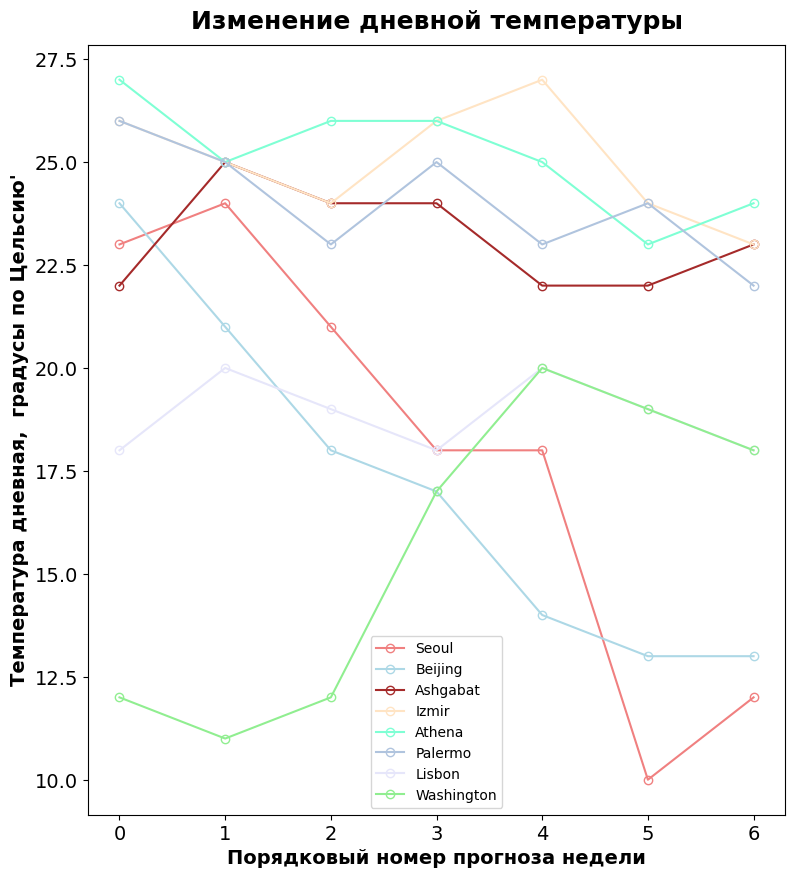

In [ ]:
# Посмотрим изменение дневной температуры для выбранных городов
# зададим параметры для нашего графика
plt.rcParams['figure.figsize'] = [9, 10]

# определим данные для отображения, проставим маркеры и выберем цвет
plt.plot(df_seoul.index, df_seoul.day_temperature, marker='o', markerfacecolor = "None", color='lightcoral', label='Seoul')
plt.plot(df_beijing.index, df_beijing.day_temperature, marker='o', markerfacecolor = "None", color='lightblue', label='Beijing')
plt.plot(df_ashgabat.index, df_ashgabat.day_temperature, marker='o', markerfacecolor = "None", color='brown', label='Ashgabat')
plt.plot(df_izmir.index, df_izmir.day_temperature, marker='o', markerfacecolor = "None", color='bisque', label='Izmir')
plt.plot(df_athena.index, df_athena.day_temperature, marker='o', markerfacecolor = "None", color='aquamarine', label = 'Athena')
plt.plot(df_palermo.index, df_palermo.day_temperature, marker='o', markerfacecolor = "None", color='lightsteelblue', label='Palermo')
plt.plot(df_lisbon.index, df_lisbon.day_temperature, marker='o', markerfacecolor = "None", color='lavender', label='Lisbon')
plt.plot(df_washington.index, df_washington.day_temperature, marker='o', markerfacecolor = "None", color='lightgreen', label='Washington')

# добавим обозначения на график: подписи осей, название графика
plt.title('Изменение дневной температуры', fontsize=18, fontweight="bold", y=1.01)
plt.xlabel("Порядковый номер прогноза недели", fontsize=14, fontweight="bold")
plt.ylabel("Температура дневная,  градусы по Цельсию'", fontsize=14, fontweight="bold")
plt.tick_params(labelsize=14)


plt.legend();

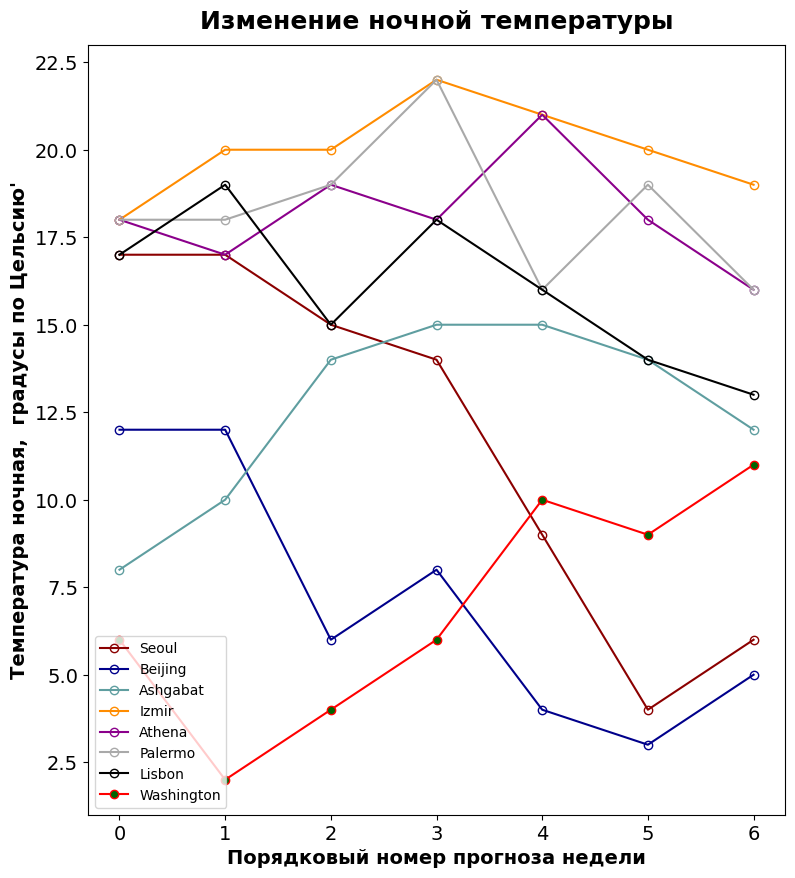

In [ ]:
# Посмотрим изменение ночной температуры для выбранных городов
# зададим параметры для нашего графика
plt.rcParams['figure.figsize'] = [9, 10]

# определим данные для отображения, проставим маркеры и выберем цвет
plt.plot(df_seoul.index, df_seoul.night_temperature, marker='o', markerfacecolor = "None", color='darkred', label='Seoul')
plt.plot(df_beijing.index, df_beijing.night_temperature, marker='o', markerfacecolor = "None", color='darkblue', label='Beijing')
plt.plot(df_ashgabat.index, df_ashgabat.night_temperature, marker='o', markerfacecolor = "None", color='cadetblue', label='Ashgabat')
plt.plot(df_izmir.index, df_izmir.night_temperature, marker='o', markerfacecolor = "None", color='darkorange', label='Izmir')
plt.plot(df_athena.index, df_athena.night_temperature, marker='o', markerfacecolor = "None", color='darkmagenta', label = 'Athena')
plt.plot(df_palermo.index, df_palermo.night_temperature, marker='o', markerfacecolor = "None", color='darkgrey', label='Palermo')
plt.plot(df_lisbon.index, df_lisbon.night_temperature, marker='o', markerfacecolor = "None", color='black', label='Lisbon')
plt.plot(df_washington.index, df_washington.night_temperature, marker='o', markerfacecolor = "darkgreen", color='red', label='Washington')

# добавим обозначения на график: подписи осей, название графика
plt.title('Изменение ночной температуры', fontsize=18, fontweight="bold", y=1.01)
plt.xlabel("Порядковый номер прогноза недели", fontsize=14, fontweight="bold")
plt.ylabel("Температура ночная,  градусы по Цельсию'", fontsize=14, fontweight="bold")
plt.tick_params(labelsize=14)


plt.legend();

Мы построили карту для отображения нашей выборки городов, привязав к их координатам.

По каждому из городов спарсили данные по погоде на неделю с сайта Яндекс.погода, забрав данные по дневной и ночной температурах и погодных условиях.

После визуализации наших данных, наглядно видно, что для городов, находящихся примерно на одной широте, разброс как дневных температур, так и ночных, достаточно высок.


Более стабильный разброс прогнозируемых дневных температур для ближайшей недели, судя по графику, характерен для центральных районов (Измир, Палермо, Лиссабон) исследуемой широты.

Более плавное изменение прогнозируемых ночных температур характерно для Ашхабада.

In [ ]:
# P.s. Выборка городов осуществлялась фильтром (Near Latitude -> 40-31) при помощи сайта https://blog.batchgeo.com/cities-by-latitude-and-longitude/ ,
# отправной точкой являлся Сеул (широта которого была округлена в сторону потолка диапазона для поиска городов для анализа)